### Decision Trees

In [2]:
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
from nltk.corpus import stopwords
import datetime as dt
import warnings
import string
from sklearn.feature_extraction.text import TfidfVectorizer

df_train = pd.read_csv('train.csv')
df_resources = pd.read_csv('resources.csv')
train_resource = pd.merge(df_train, df_resources, on="id", how='left')
df_train[df_train.teacher_prefix.isnull()]
train_resource[train_resource.description.isnull()].head()
t2 = train_resource.pivot_table(index = ['id', 'description'],
                                values='quantity', 
                                aggfunc=np.sum)
t2.reset_index(inplace=True)
train_resource = pd.merge(train_resource,
                          t2, 
                          on=['id', 'description'], 
                          how='right',
                          suffixes=('_Orig', '_True'))

train_resource = train_resource.drop_duplicates()
train_resource = train_resource.drop('quantity_Orig', axis=1)
train_resource = train_resource.rename(columns={'quantity_True': 'True_Quantity'})
train_resource['Total_Cost'] = train_resource.price * train_resource.True_Quantity
Total_cost = train_resource.pivot_table(values=['Total_Cost','True_Quantity'],
                                        index='id',
                                        aggfunc={'Total_Cost' : np.sum, 'True_Quantity' : np.sum})
Total_cost.reset_index(level=0, inplace = True)

df_train = df_train.merge(Total_cost, on='id', how='left')
df_train['Average_item_cost'] = df_train.Total_Cost  / df_train.True_Quantity

df_train['text'] = df_train.apply(lambda row: ' '.join([str(row['project_essay_1']), 
                                                        str(row['project_essay_2']), 
                                                        str(row['project_essay_3']), 
                                                        str(row['project_essay_4'])]), axis=1
                                                      )                               

df = df_train

stop_words = list(set(stopwords.words('english')))
warnings.filterwarnings('ignore')
punctuation = string.punctuation

df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 182080 entries, 0 to 182079
Data columns (total 20 columns):
id                                              182080 non-null object
teacher_id                                      182080 non-null object
teacher_prefix                                  182076 non-null object
school_state                                    182080 non-null object
project_submitted_datetime                      182080 non-null object
project_grade_category                          182080 non-null object
project_subject_categories                      182080 non-null object
project_subject_subcategories                   182080 non-null object
project_title                                   182080 non-null object
project_essay_1                                 182080 non-null object
project_essay_2                                 182080 non-null object
project_essay_3                                 6374 non-null object
project_essay_4                        

In [3]:
#https://github.com/eclarson/DataMiningNotebooks/blob/master/04.%20Logits%20and%20SVM.ipynb
from __future__ import print_function

df["three_r"] = np.logical_or(df["project_subject_categories"].str.contains("Literacy & Language")
                             ,df["project_subject_categories"].str.contains("Math & Science")
                             )

# Remove attributes that arent useful
if 'project_essay_3' in df:
    del df['project_essay_3']
if 'project_essay_4' in df:    
    del df['project_essay_4']

# drop rows that still had missing values after grouped imputation
df.dropna(inplace=True)

# extract length of each essay and title
df['essay1_DescribeStudents_len'] = df['project_essay_1'].apply(len)
df['essay2_AboutProject_len'] = df['project_essay_2'].apply(len)
df['title_len'] = df['project_title'].apply(len)

# take natural log of right skewed attributes
df['teacher_number_of_previously_posted_projects']=np.log1p(df.teacher_number_of_previously_posted_projects)
df['Total_Cost']=np.log1p(df.Total_Cost)
df['True_Quantity']=np.log1p(df.True_Quantity)
df['Average_item_cost']=np.log1p(df.Average_item_cost)
df['essay1_DescribeStudents_len']=np.log1p(df.essay1_DescribeStudents_len)
df['essay2_AboutProject_len']=np.log1p(df.essay2_AboutProject_len)
df['title_len']=np.log1p(df.title_len)

# perform one-hot encoding of the categorical data
tmp_df = pd.get_dummies(df.teacher_prefix,prefix='teacher_prefix')
df = pd.concat((df,tmp_df),axis=1) # add back into the dataframe

tmp_df = pd.get_dummies(df.project_grade_category,prefix='project_grade_category')
df = pd.concat((df,tmp_df),axis=1) # add back into the dataframe

# Keep these attributes
df = df[['teacher_number_of_previously_posted_projects','Total_Cost','True_Quantity','Average_item_cost','project_is_approved'
        ,'teacher_prefix_Teacher','project_grade_category_Grades PreK-2'
        ,'essay1_DescribeStudents_len','essay2_AboutProject_len','title_len','text'
        ,'three_r']]

# preserve final dataset
df2 = df
    
df.info()
df.describe()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 182073 entries, 0 to 182079
Data columns (total 12 columns):
teacher_number_of_previously_posted_projects    182073 non-null float64
Total_Cost                                      182073 non-null float64
True_Quantity                                   182073 non-null float64
Average_item_cost                               182073 non-null float64
project_is_approved                             182073 non-null int64
teacher_prefix_Teacher                          182073 non-null uint8
project_grade_category_Grades PreK-2            182073 non-null uint8
essay1_DescribeStudents_len                     182073 non-null float64
essay2_AboutProject_len                         182073 non-null float64
title_len                                       182073 non-null float64
text                                            182073 non-null object
three_r                                         182073 non-null bool
dtypes: bool(1), float64(7), int64(

,teacher_number_of_previously_posted_projects,Total_Cost,True_Quantity,Average_item_cost,project_is_approved,teacher_prefix_Teacher,project_grade_category_Grades PreK-2,essay1_DescribeStudents_len,essay2_AboutProject_len,title_len
count,182073.000000,182073.000000,182073.000000,182073.000000,182073.000000,182073.000000,182073.000000,182073.000000,182073.000000,182073.000000
mean,1.440580,6.021158,2.330753,3.916123,0.847676,0.021486,0.405821,6.447078,6.674833,3.429738
std,1.318374,0.740747,1.039543,1.282055,0.359335,0.144998,0.491052,0.335587,0.314533,0.407495
min,0.000000,4.313212,0.693147,0.230229,0.000000,0.000000,0.000000,3.931826,5.517453,1.609438
25%,0.000000,5.514759,1.609438,2.891869,1.000000,0.000000,0.000000,6.246107,6.458338,3.135494
50%,1.098612,5.990964,2.302585,3.848531,1.000000,0.000000,0.000000,6.406880,6.595781,3.433987
75%,2.302585,6.549365,3.091042,4.918228,1.000000,0.000000,1.000000,6.663133,6.858565,3.737670
max,6.113682,9.700169,7.247793,9.210340,1.000000,1.000000,1.000000,7.923348,8.561210,4.955827


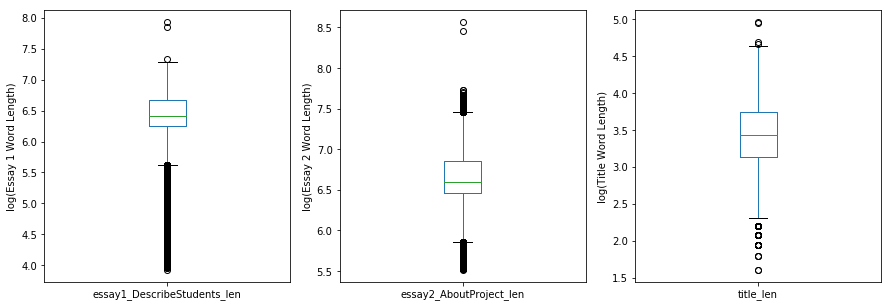

In [4]:
plt.figure(figsize = (15,5))
plt.subplot(1,3,1)
df.essay1_DescribeStudents_len.plot(kind='box')
plt.ylabel('log(Essay 1 Word Length)')
plt.subplot(1,3,2)
df.essay2_AboutProject_len.plot(kind='box')
plt.ylabel('log(Essay 2 Word Length)')
plt.subplot(1,3,3)
df.title_len.plot(kind='box')
plt.ylabel('log(Title Word Length)')
plt.show()

In [5]:
# now divide the data into test and train using scikit learn built-ins
from sklearn.model_selection import StratifiedShuffleSplit 

cv = StratifiedShuffleSplit(n_splits=1,train_size=0.5)
print (cv)

if 'text' in df:
         del df['text'] # get rid of this for now
    
# we want to predict the X and y data as follows:
if 'project_is_approved' in df:
    y = df['project_is_approved'].values # get the labels we want
    del df['project_is_approved'] # get rid of the class label
    X = df.values # use everything else to predict!

StratifiedShuffleSplit(n_splits=1, random_state=None, test_size='default',
            train_size=0.5)


In [6]:
from sklearn.tree import DecisionTreeClassifier
from sklearn import metrics as mt

dt_clf = DecisionTreeClassifier()

# now get the training and testing
for train, test in cv.split(X,y):
    print ('Training Once:')
    # train the decision tree algorithm
    %time dt_clf.fit(X[train],y[train])
    yhat = dt_clf.predict(X[test])
    print ('accuracy:', mt.accuracy_score(y[test],yhat))

Training Once:
CPU times: user 1.09 s, sys: 14.6 ms, total: 1.1 s
Wall time: 1.1 s
accuracy: 0.7365992970123023


In [7]:
# from the tutorial: http://www.kaggle.com/c/datasciencebowl/details/tutorial 
def multiclass_log_loss(y_true, y_pred, eps=1e-15):
    """Multi class version of Logarithmic Loss metric.
    https://www.kaggle.com/wiki/MultiClassLogLoss

    Parameters
    ----------
    y_true : array, shape = [n_samples]
            true class, integers in [0, n_classes - 1)
    y_pred : array, shape = [n_samples, n_classes]

    Returns
    -------
    loss : float
    """
    predictions = np.clip(y_pred, eps, 1 - eps)

    # normalize row sums to 1
    predictions /= predictions.sum(axis=1)[:, np.newaxis]

    actual = np.zeros(y_pred.shape)
    n_samples = actual.shape[0]
    actual[np.arange(n_samples), y_true.astype(int)] = 1
    vectsum = np.sum(actual * np.log(predictions))
    loss = -1.0 / n_samples * vectsum
    return loss

In [8]:
yhat = dt_clf.predict(X[test])
class_probabilities = dt_clf.predict_proba(X[test])
print ('Accuracy:', mt.accuracy_score(y[test],yhat))
print ('Log Loss:', multiclass_log_loss(y[test], class_probabilities))

Accuracy: 0.7365992970123023
Log Loss: 9.097537982754373


In [9]:
from sklearn.decomposition import PCA

n_components = 10
pca = PCA(n_components=n_components, svd_solver='randomized')

for train, test in cv.split(X,y):
    print ('Training Once:')
    
    # transform the data using pca
    pca.fit(X[train])
    X_train = pca.transform(X[train])
    X_test = pca.transform(X[test])
    
    # train the decision tree algorithm
    dt_clf.fit(X_train,y[train])
    yhat = dt_clf.predict(X_test)
    class_probabilities = dt_clf.predict_proba(X_test)
    
    print ('Accuracy:', mt.accuracy_score(y[test],yhat))
    print ('Log Loss:', multiclass_log_loss(y[test], class_probabilities))

Training Once:
Accuracy: 0.741706942003515
Log Loss: 8.919267341610862


In [10]:
log_losses = []
accuracies = []
params = []

from matplotlib import pyplot as plt
%matplotlib inline

Training Once:
Accuracy: 0.8477043057996485
Log Loss: 0.4139587116788612


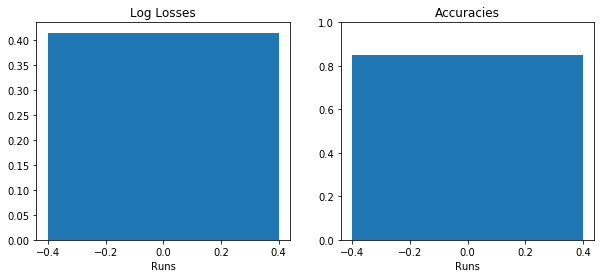

In [11]:
# how to make it generalize a bit better? 

# defaults
dt_clf = DecisionTreeClassifier(criterion='gini', max_depth=None, 
                                min_samples_split=2, min_samples_leaf=1, 
                                max_features=None,
                                max_leaf_nodes=None)

# overwrite with prepruning methods
dt_clf = DecisionTreeClassifier(criterion='entropy', max_depth=5, 
                                min_samples_split=1000, min_samples_leaf=1, 
                                max_leaf_nodes=None)

for train, test in cv.split(X,y):
    print ('Training Once:')
    
    # transform the data using pca
    pca.fit(X[train])
    X_train = pca.transform(X[train])
    X_test = pca.transform(X[test])
    
    # train the decision tree algorithm
    dt_clf.fit(X_train,y[train])
    yhat = dt_clf.predict(X_test)
    class_probabilities = dt_clf.predict_proba(X_test)
    
    # get accuracy and log loss of this training
    acc = mt.accuracy_score(y[test],yhat)
    ll = multiclass_log_loss(y[test], class_probabilities)
    print ('Accuracy:', acc)
    print ('Log Loss:', ll)
    
    # save accuracy, log loss, and params of run
    log_losses.append(ll)
    accuracies.append(acc)
    params.append(dt_clf.get_params())
    
plt.figure(figsize=(10,4))
plt.subplot(1,2,1)
plt.bar(range(len(log_losses)),log_losses)
plt.title('Log Losses')
plt.xlabel('Runs')

plt.subplot(1,2,2)
plt.bar(range(len(accuracies)),accuracies)
plt.title('Accuracies')
plt.xlabel('Runs')
plt.ylim([0,1])

plt.show()

In [12]:
# a telling example for log loss minimization
class_probabilities = np.ones((len(y[test]),len(np.unique(y))))
print ('Log Loss of "Chance":', multiclass_log_loss(y[test], class_probabilities))

Log Loss of "Chance": 0.6931471805599453
